In [1]:
from cut_qaoa import *

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.primitives import BackendEstimator,BackendSampler

In [3]:
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz

from qiskit import transpile
from qiskit_aer import AerSimulator
# from qiskit.visualization import plot_distribution
#from qiskit.quantum_info import SparsePauliOp
# Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
# from rustworkx.visualization import mpl_draw

In [4]:

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



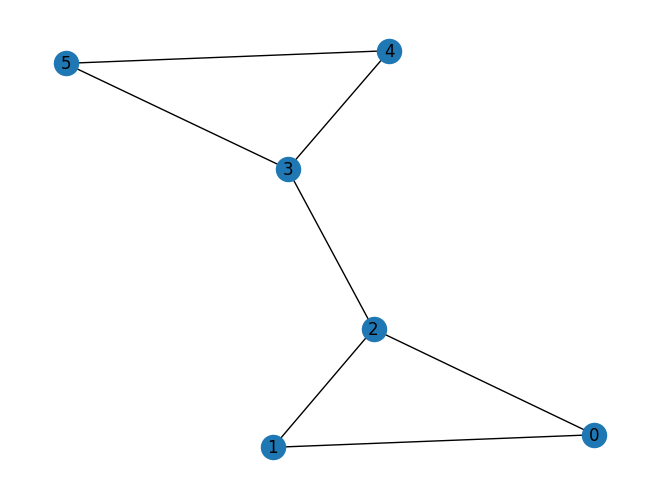

In [5]:


seed = 12
num_nodes = 6



# G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
# nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))


G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(3,2),(4,3),(5,3),(4,5)])
nx.draw_spring(G, with_labels=True)
maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [6]:
# Initialize the weight matrix
w = np.zeros((num_nodes, num_nodes))

# Iterate over the edges of the graph and assign weights to the weight matrix
for edge in G.edges():
    node1, node2 = edge
    w[node1][node2] = 1
    w[node2][node1] = 1  # Assuming undirected graph

# Print the weight matrix
#print("Weight Matrix:")
#print(w)

In [7]:
import time
pos = nx.spring_layout(G)

case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 0, 0, 0, 0] cost = 2.0
case = [0, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0] cost = 3.0
case = [0, 1, 1, 0, 0, 0] cost = 3.0
case = [1, 1, 1, 0, 0, 0] cost = 1.0
case = [0, 0, 0, 1, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0] cost = 5.0
case = [1, 1, 0, 1, 0, 0] cost = 5.0
case = [0, 0, 1, 1, 0, 0] cost = 4.0
case = [1, 0, 1, 1, 0, 0] cost = 4.0
case = [0, 1, 1, 1, 0, 0] cost = 4.0
case = [1, 1, 1, 1, 0, 0] cost = 2.0
case = [0, 0, 0, 0, 1, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0] cost = 4.0
case = [0, 1, 0, 0, 1, 0] cost = 4.0
case = [1, 1, 0, 0, 1, 0] cost = 4.0
case = [0, 0, 1, 0, 1, 0] cost = 5.0
case = [1, 0, 1, 0, 1, 0] cost = 5.0
case = [0, 1, 1, 0, 1, 0] cost = 5.0
case = [1, 1, 1, 0, 1, 0] cost = 3.0
case = [0, 0, 0, 1, 1, 0] cost = 3.0
case = [1, 0, 0, 1, 1, 0] cost = 5.0
case = [0, 1, 0, 1, 1, 0] cost = 5.0
c

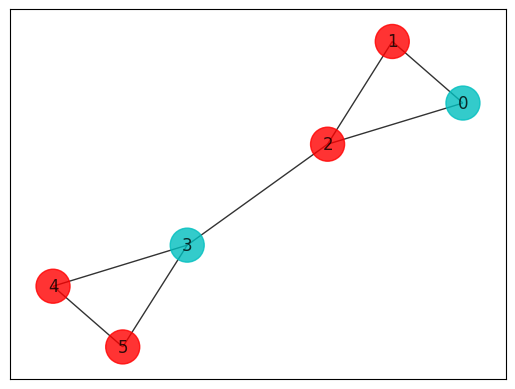

In [8]:
tic = time.time()
best_cost_brute = 0
for b in range(2**num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(num_nodes)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

In [9]:
print(len(G.nodes()))

6


In [10]:
x0 = 2 * np.pi * np.random.rand(4)
print(x0)

[1.32051822 6.24166783 2.75378935 2.34508305]


In [11]:

from scipy.optimize import minimize
expectation = get_expectation(G)
res = minimize(expectation,
               x0,
               method='POWELL')

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 3 times.
MIP Presolve eliminated 37 rows and 8 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 237 substitutions.
Reduced MIP has 966 rows, 321 columns, and 2806 nonzeros.
Reduced MIP has 315 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (4.79 ticks)
Probing fixed 76 vars, tightened 1 bounds.
Probing changed sense of 126 constraints.
Probing time = 0.00 sec. (4.98 ticks)
Cover probing fixed 8 vars, tightened 65 bounds.
Tried aggregator 3 times.
MIP Presolve eliminated 895 rows and 250 columns.
MIP Presolve modified 127 coefficients.
Aggregator did 71 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (4.07 ticks)

Root node processing (before b&c):
  Real tim